In [1495]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1496]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf


import warnings
warnings.filterwarnings('ignore')

# Sneak peek at the dataset

In [1497]:
df = pd.read_csv('googleplaystore2.csv')

#print(df.dtypes)
#df.loc[df.App=='Tiny Scanner - PDF Scanner App']
# df[df.duplicated(keep='first')]
df.drop_duplicates(subset='App', inplace=True)
print(len(df))

3091


In [1498]:
#df.sample(10)

## Data Cleaning
 - Convert all app sizes to MB
 - Remove '+' from number of installs to make it numeric
 - Remove emojis from reviews

In [1499]:

# - Installs : Remove + and ,

df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: int(x))
#print(type(df['Installs'].values))


In [1500]:
# - Size : Remove 'M', Replace 'k' and divide by 10^-3
#df['Size'] = df['Size'].fillna(0)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)

df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)


df['Size'] = df['Size'].apply(lambda x: float(x))
df['Installs'] = df['Installs'].apply(lambda x: float(x))

df['Price'] = df['Price'].apply(lambda x: x.replace('$', '') if '$' in x else x)
df['Price'] = df['Price'].apply(lambda x: float(x))
#df['Reviews'] = df['Reviews'].apply(lambda x: 'NaN' if int(x) == 0 else int(x))
#print(df.loc[df.Size == 0.713]) #index = 3384
#df.loc[df.col1 == '']['col2']

# 0 - Free, 1 - Paid
# df['Type'] = pd.factorize(df['Type'])[0]
#print(df.dtypes)

In [1501]:
# paid_or_free = df['Type'].value_counts()
# paid_or_free

# grouped_df = df.groupby('Category')

# print(grouped_df)
# for key, item in grouped_df:
#     print (item, "\n\n")
    
# d = df.groupby(['Type', 'Category']).agg({'App' : ['count']})
# d.columns = d.columns.droplevel(0)
# d

## Basic EDA

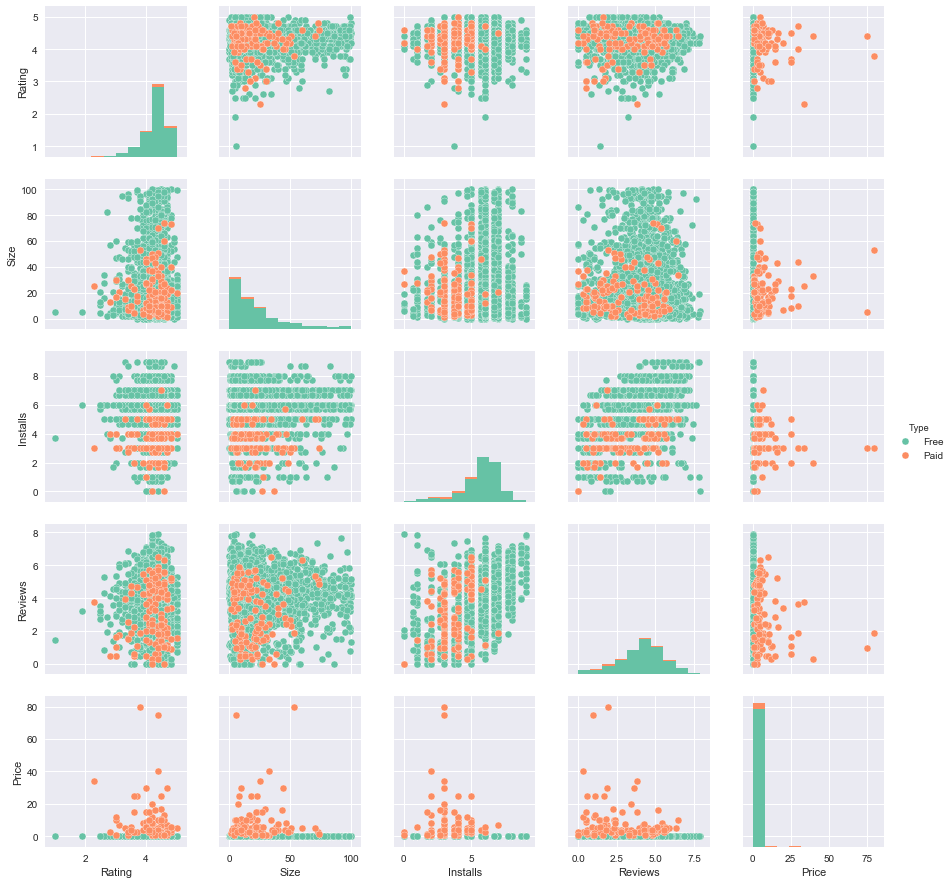

In [1502]:
#print(df.dtypes)


x = df['Rating'].dropna()
y = df['Size'].dropna()
z = df['Installs'].dropna()
p = df['Reviews'][df.Reviews!=0]
t = df['Type']
price = df['Price']
p = sns.pairplot(pd.DataFrame(list(zip(x, y, np.log10(z), np.log10(p), t, price)), 
                        columns=['Rating','Size', 'Installs', 'Reviews', 'Type', 'Price']), hue='Type', palette="Set2")

    This is the basic exploratory analysis to look for any evident patterns or relationships between the features. 

## Android market breakdown
Which category has the highest share of (active) apps in the market?

In [1503]:

number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')


# avg_rating_per_category = df.groupby('Category').agg({'Rating' : 'mean'})
# #avg_rating_per_category.columns = avg_rating_per_category.columns.droplevel(0)
# avg_rating_per_category = avg_rating_per_category.sort_values(by='Rating', ascending = False)
# print(avg_rating_per_category.index, avg_rating_per_category.Rating)
# data = [go.Bar(
#             y=avg_rating_per_category.index[:10],
#             x=avg_rating_per_category['Rating'][:10],
#             orientation = 'h',
            
# )]

# plotly.offline.iplot(data)

- **Game** apps have the highest market prevelance. 
- Interestingly, **Medical** apps are also catching up.

## Average rating of apps
Do any apps perform really good or really bad?

In [1504]:
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print(np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

4.275033921302587


Generally, most apps do well with an average rating of **4.28**.

Let's break this down and inspect if we have categories which perform exceptionally good or bad.

## App ratings across categories - One Way Anova Test

F_onewayResult(statistic=18.895176351489315, pvalue=5.075720888719046e-27)

The p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.



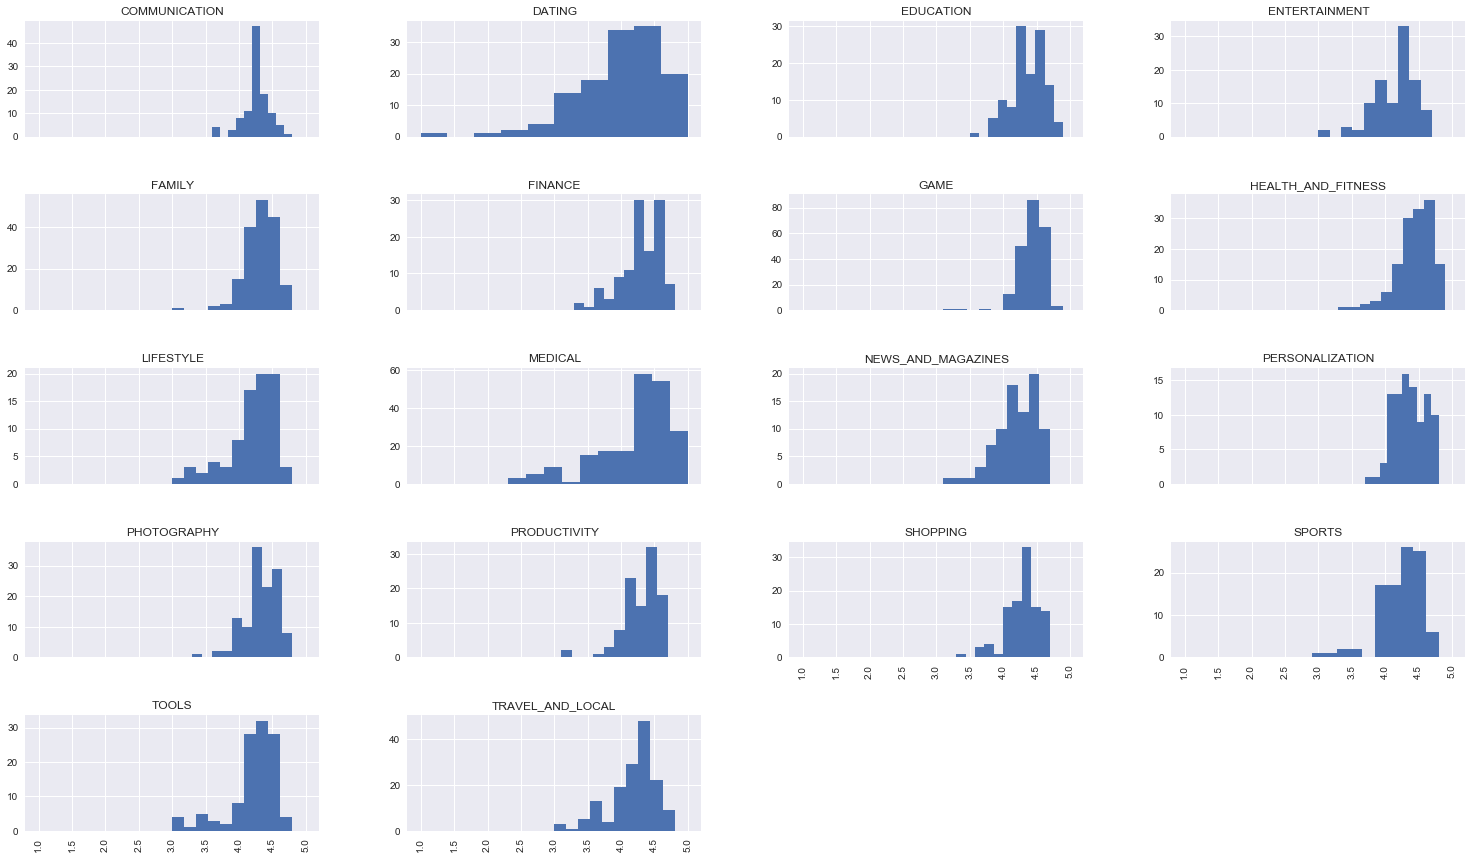

In [1505]:
import scipy.stats as stats
f = stats.f_oneway(df.loc[df.Category == 'BUSINESS']['Rating'].dropna(), 
               df.loc[df.Category == 'FAMILY']['Rating'].dropna(),
               df.loc[df.Category == 'GAME']['Rating'].dropna(),
               df.loc[df.Category == 'DATING']['Rating'].dropna(),
               df.loc[df.Category == 'HEALTH_AND_FITNESS']['Rating'].dropna(),
               df.loc[df.Category == 'FINANCE']['Rating'].dropna(),
               df.loc[df.Category == 'EDUCATION']['Rating'].dropna(),
               df.loc[df.Category == 'MEDICAL']['Rating'].dropna(),
               df.loc[df.Category == 'TOOLS']['Rating'].dropna(),
              )

print(f)
print('\nThe p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.\n')
#temp = df.loc[df.Category.isin(['BUSINESS', 'DATING'])]

groups = df.groupby('Category').filter(lambda x: len(x) > 80).reset_index()
array = groups['Rating'].hist(by=groups['Category'], sharex=True)

    An app's rating is dependent on the category it comes from.

## Best performing categories

In [1506]:

# boxplot = sns.boxplot(x='category', y='rating', data=df)
# _ = [item.set_rotation(90) for item in boxplot.get_xticklabels()]


groups = df.groupby('Category').filter(lambda x: len(x) >= 100).reset_index()
#print(type(groups.item.['BUSINESS']))
print('Average rating = ', np.nanmean(list(groups.Rating)))
#print(len(groups.loc[df.Category == 'DATING']))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(set(groups.Category)))]


#df_sorted = df.groupby('Category').agg({'Rating':'median'}).reset_index().sort_values(by='Rating', ascending=False)
#print(df_sorted)

layout = {'title' : 'App ratings across categories',
        'xaxis': {'tickangle':-45},
          #'yaxis:' :{'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -1,
              'y0': np.nanmean(list(groups.Rating)),
              'x1': 15,
              'y1': np.nanmean(list(groups.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(groups.Category)))]



plotly.offline.iplot({'data': data, 'layout': layout})



Average rating =  4.27311320754717



- Almost all app categories perform decently. Categories like **Health and Fitness**, **Education** and **Game** produce the highest quality apps. More than 75% of the apps in these categories have a rating greater than the average rating.


- On the contrary, more than 50% of apps in the **Dating** and **Entertainment** category have a rating lesser than the average rating. 


- A few **junk apps** also exist in the **Medical** and **Dating** category.


# Sizing Strategy - Light Vs Bulky?

How do app sizes impact the app rating?

In [1507]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()

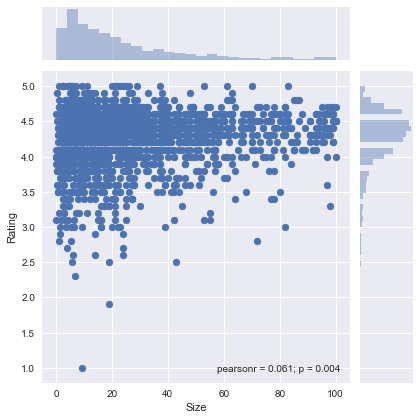

In [1508]:
# sns.set_style('ticks')
# fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size'], df['Rating'])

Most top rated apps are optimally sized between **~2MB to ~40MB** - neither too light nor too heavy.

In [1509]:

c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(list(set(groups.Category))))]

subset_df = df[df.Size > 5]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

# for category in enumerate(list(set(groups_temp.Category))):
#     print (category)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    #'marker': {'color':c[i]}
    #'text' : df['rating'],
    } for category in enumerate(['GAME', 'FAMILY'])]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

# heavy_categories = [ 'ENTERTAINMENT', 'MEDICAL', 'DATING']

# data = [{
#     'x': groups.loc[df.Category==category]['Rating'], 
#     'type':'scatter',
#     'y' : df['Size'],
#     'name' : category,
#     'mode' : 'markers',
#     'showlegend': True,
#     #'text' : df['rating'],
#     } for category in heavy_categories]

Most bulky apps ( >50MB) belong to the **Game**, **Medical** and **Family** category. Despite this, these bulky apps are fairly highly rated indicating that they are bulky for a purpose.

# Pricing Strategy - Free Vs Paid?

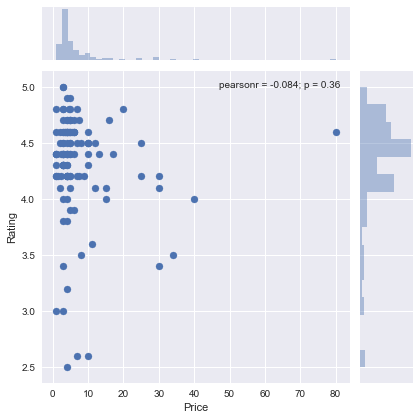

In [1510]:
paid_apps = df[df.Price>0]
p = sns.jointplot( "Price", "Rating", paid_apps)

Most top rated apps are optimally priced between **~2\$ to ~20\$** - neither too cheap nor too expensive.

In [1511]:
# fig, ax = plt.subplots()
# fig.set_size_inches(8, 8)

# data = [{
#     'x': df['Rating'], 
#     'type':'scatter',
#     'y' : df['Price'],
#     'mode' : 'markers',
#     #'text' : df['rating'],
#     } ]


# layout = {'title':"Rating vs Price", 
#           'xaxis': {'title' : 'Rating'},
#           'yaxis' : {'title' : 'Price'},
#          'plot_bgcolor': 'rgb(0,0,0)'}

# plotly.offline.iplot({'data': data, 'layout': layout})

## Current pricing trend - How to price your app?

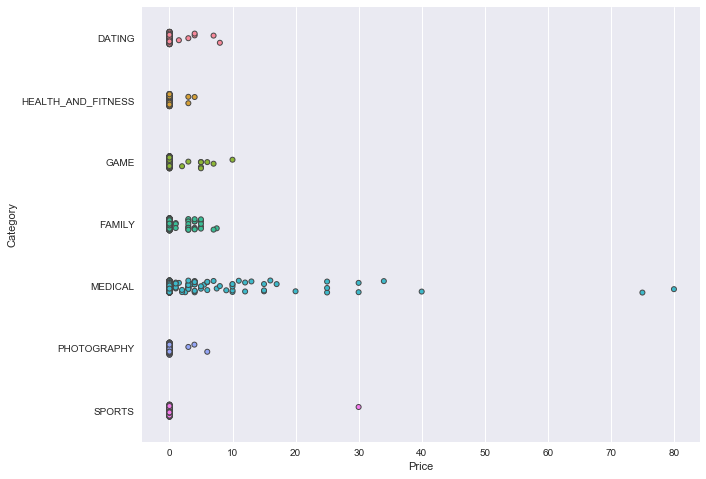

In [1512]:
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'DATING', 'SPORTS', 'HEALTH_AND_FITNESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax = sns.stripplot(x="Price", y="Category", data=subset_df, jitter=True, linewidth=1)

Clearly, **Medical apps** are the most expensive.

## Distribution of paid and free apps across categories

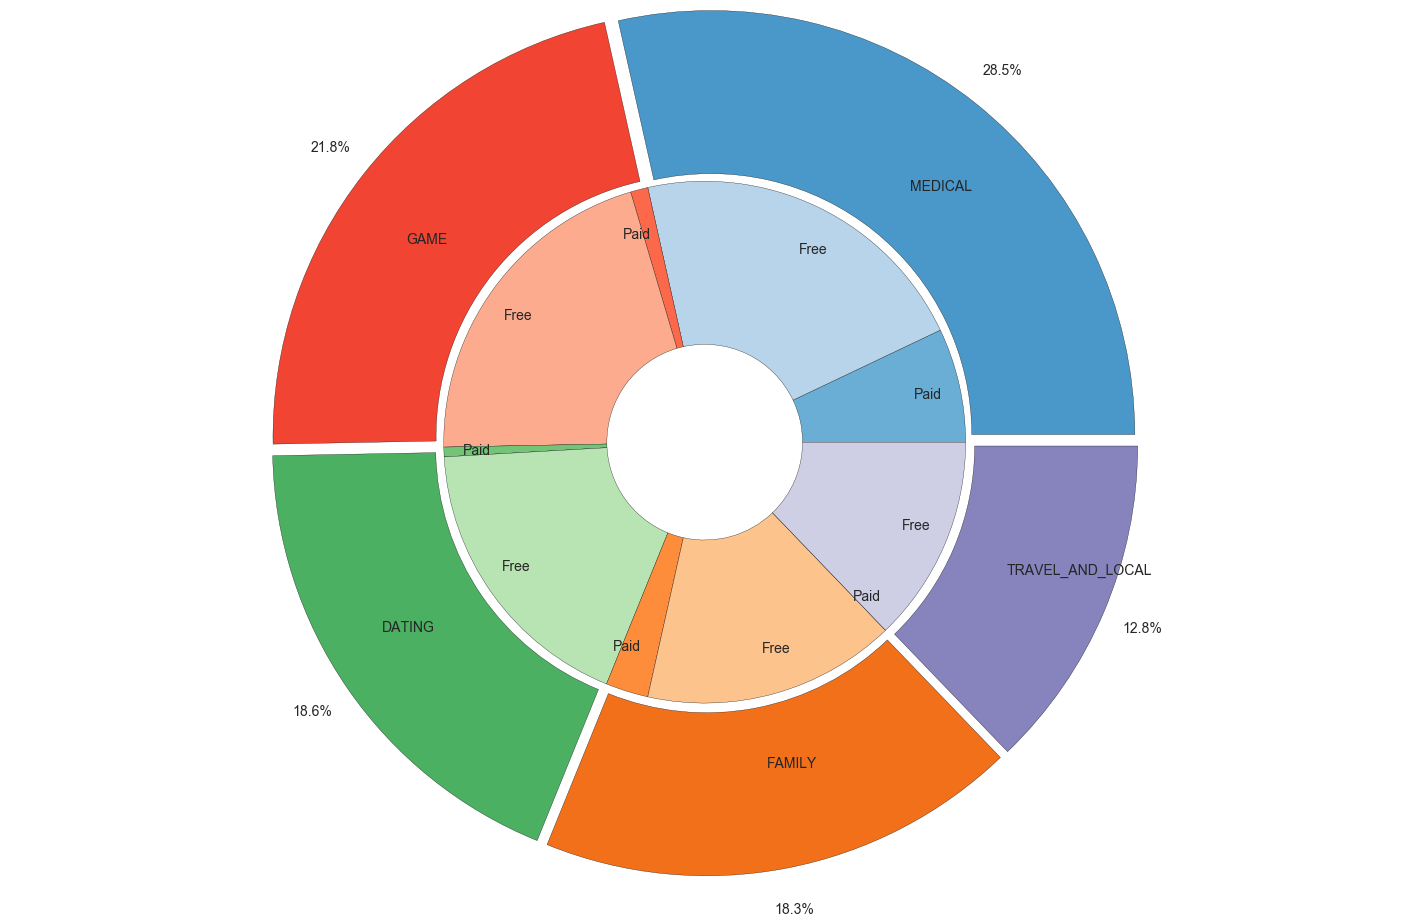

In [1643]:
# Stacked bar graph for top 5-10 categories - Ratio of paid and free apps
#fig, ax = plt.subplots(figsize=(15,10))

new_df = df.groupby(['Category', 'Type']).agg({'App' : 'count'}).reset_index()
#print(new_df)

outer_group_names = df['Category'].sort_values().value_counts()[:5].index
outer_group_values = df['Category'].sort_values().value_counts()[:5].values

a, b, c, d, e=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges, plt.cm.Purples]


inner_group_names = ['Paid', 'Free'] * 5
inner_group_values = []
#inner_colors = ['#58a27c','#FFD433']


for category in outer_group_names:
    for t in ['Paid', 'Free']:
        x = new_df[new_df.Category == category]
        try:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(int(x.App[x.Type == t].values[0]))
        except:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(0)

explode = (0.03,0.03,0.03,0.03, 0.03)
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, texts, _ = ax.pie(outer_group_values, radius=1.3, labels=outer_group_names, autopct='%1.1f%%', pctdistance=1.1,
                                 labeldistance= 0.75,  explode = explode, colors=[a(0.6), b(0.6), c(0.6), d(0.6), e(0.6)], textprops={'fontsize': 14})
plt.setp( mypie, width=0.5, edgecolor='black')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(inner_group_values, radius=1.3-0.5, labels=inner_group_names, labeldistance= 0.82, 
                   textprops={'fontsize': 14}, colors = [a(0.5), a(0.3), b(0.5), b(0.3), c(0.5), c(0.3), d(0.5), d(0.3), e(0.5), e(0.3)])
plt.setp( mypie2, width=0.5, edgecolor='black')
plt.margins(0,0)
 
# show it
plt.show()



#ax = sns.countplot(x="Category", hue="Type", data=new_df)

#df.groupby(['Category', 'Type']).count()['App'].unstack().plot(kind='bar', stacked=True, ax=ax)
#ylabel = plt.ylabel('Number of apps')



# Are paid apps downloaded as much as free apps?

In [1514]:
type_groups = df.groupby('Type')

data = [{
    'x': type_groups.get_group(t)['Rating'], 
    'type':'scatter',
    'y' : np.log10(df['Installs']),
    'name' : t,
    'mode' : 'markers',
    'showlegend': True,
    #'text' : df['rating'],
    } for t in set(df.Type)]


layout = {'title':"Rating vs Number of downloads", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Number of downloads (log scale)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

**All paid apps have a decently high number of downloads!!** This indicates that customers are open to paying for the app given the quality is assured.

# How do the sizes of paid apps and free apps vary?

In [1515]:
df = df[df.Size>0]
type_groups = df.groupby('Type')

data = [{
    'x': type_groups.get_group(t)['Rating'], 
    'type':'scatter',
    'y' : df['Size'],
    'name' : t,
    'mode' : 'markers',
    'showlegend': True,
    #'text' : df['rating'],
    } for t in set(df.Type)]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

- **Majority of the paid apps that are highly rated have small sizes.** This means that most paid apps are designed and developed to cater to specific functionalities and hence are not bulky.


- **Users prefer to pay for apps that are light-weighted.** A paid app that is bulky may not perform well in the market.

# Exploring Correlations

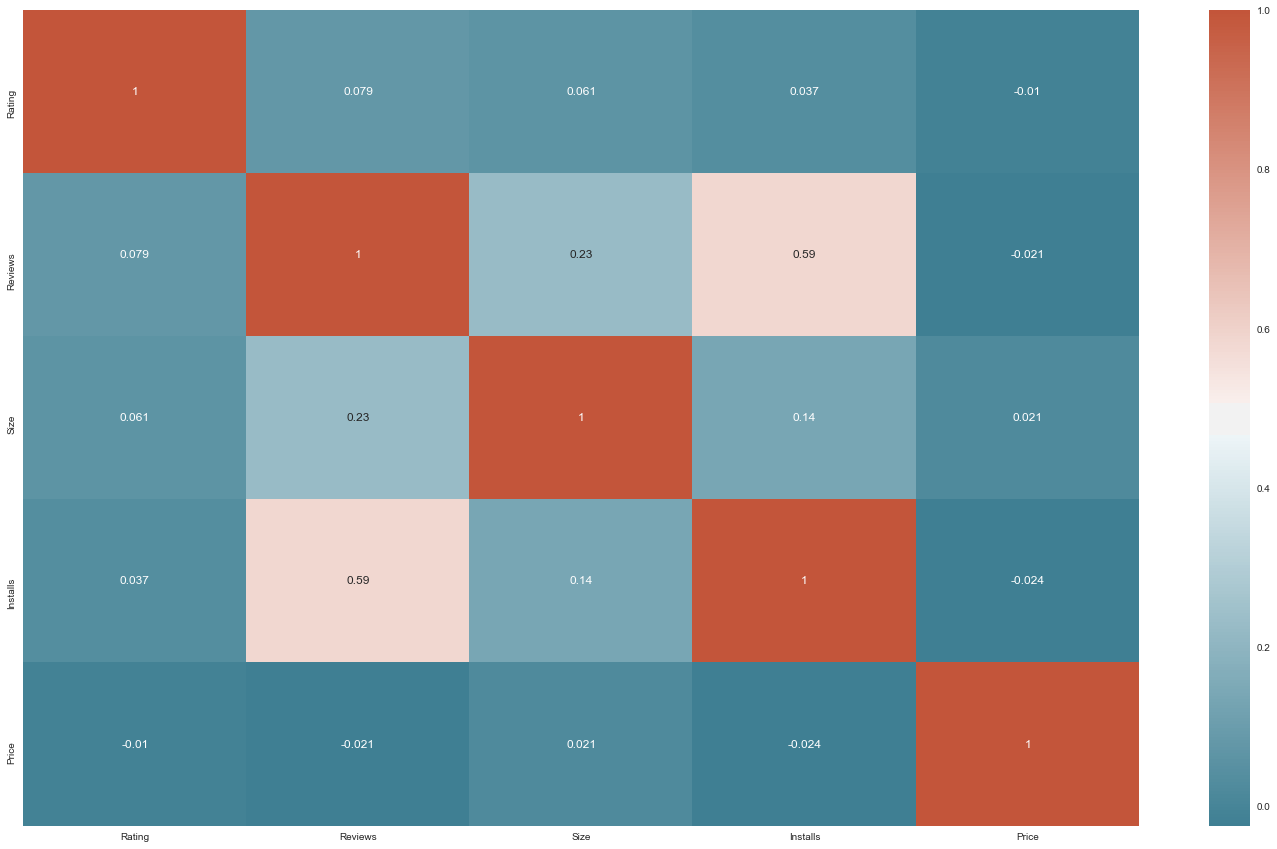

In [1516]:
#df['Installs'].corr(df['Reviews'])
#print(np.corrcoef(l, rating))

corrmat = df.corr()
#f, ax = plt.subplots()
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Seems like there is some correlation between Reviews and Installs. Let's explore this.

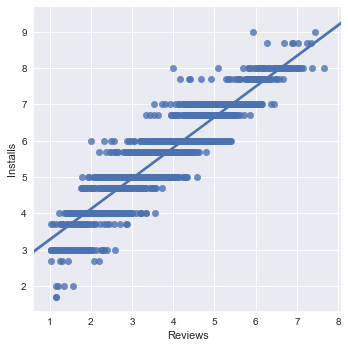

In [1517]:
df_copy = df.copy()

df_copy = df_copy[df_copy.Reviews > 10]
df_copy = df_copy[df_copy.Installs > 0]

df_copy['Installs'] = np.log10(df['Installs'])
df_copy['Reviews'] = np.log10(df['Reviews'])


ax = sns.lmplot("Reviews", "Installs", data=df_copy)

# data = [{
#     'x': df_copy['Reviews'], 
#     'type':'scattergl',
#     'y' : df_copy.Installs,
#     'mode' : 'markers',
#     #'text' : df['rating'],
# #     'marker': {'color':c[i]},
#     } ]


# layout = {'title':"Reviews vs Number of downloads", 
#           'xaxis': {'title' : 'Reviews'},
#           'yaxis' : {'title' : 'Number of downloads'},
#          'plot_bgcolor': 'rgb(0,0,0)'}

# plotly.offline.iplot({'data': data, 'layout': layout})

**A moderate positive correlation of 0.61 exists between the number of reviews and number of downloads.** This means that customers tend to download a given app more if it has been reviewed by a larger number of people. 

This also means that many active users who download an app usually also leave back a review or feedback. 

So, getting your app reviewed by more people maybe a good idea to increase your app's capture in the market!

In [1600]:
reviews_df = pd.read_csv('googleplaystore_sentiment_analysis.csv')
merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")

#df[reviews_df.Review == 'Not bad, price little bit expensive']
#merged_df.sample(10)
merged_df.dtypes

App                        object
Category                   object
Rating                    float64
Reviews                     int64
Size                      float64
Installs                  float64
Type                       object
Price                     float64
Content Rating             object
Genres                     object
Last Updated               object
Current Ver                object
Android Ver                object
Unnamed: 0                  int64
Review                     object
Translated_Review          object
Sentiment                  object
Sentiment_Polarity        float64
Sentiment_Subjectivity    float64
dtype: object

In [1596]:
#print(merged_df.isna().sum())

#fig, ax = plt.subplots(figsize=(15,10))
#groups = merged_df.groupby(['Category','Sentiment']).count()['App'].unstack().plot(kind='bar', stacked=True, ax=ax)


#grouped_df_sentiment = merged_df.groupby(['Category'])['Sentiment_Polarity'].mean().sort_values(ascending=False)
#print(grouped_df_sentiment.index)
#ax = sns.barplot(x=grouped_df_sentiment.index, y=grouped_df_sentiment.values)


#ax = sns.countplot(x="Category", hue="Sentiment", data=merged_df)

grouped_sentiment_category_count = merged_df.groupby(['Category', 'Sentiment']).agg({'App': 'count'}).reset_index()
grouped_sentiment_category_sum = merged_df.groupby(['Category']).agg({'Sentiment': 'count'}).reset_index()

new_df = pd.merge(grouped_sentiment_category_count, grouped_sentiment_category_sum, on=["Category"])
#print(new_df)
new_df['Sentiment_Normalized'] = new_df.App/new_df.Sentiment_y


trace1 = go.Bar(
    x=list(set(new_df.Category)),
    y= new_df.Sentiment_Normalized[::3],
    name='Negative',
    marker=dict(color = 'rgb(209,49,20)')
)

trace2 = go.Bar(
    x=list(set(new_df.Category)),
    y= new_df.Sentiment_Normalized[1::3],
    name='Neutral',
    marker=dict(color = 'rgb(49,130,189)')
)

trace3 = go.Bar(
    x=list(set(new_df.Category)),
    y= new_df.Sentiment_Normalized[2::3],
    name='Positive',
    marker=dict(color = 'rgb(49,189,120)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Sentiment analysis of reviews across categories',
    barmode='stack',
    yaxis = {'title': 'Fraction of reviews'}
)

fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot({'data': data, 'layout': layout})

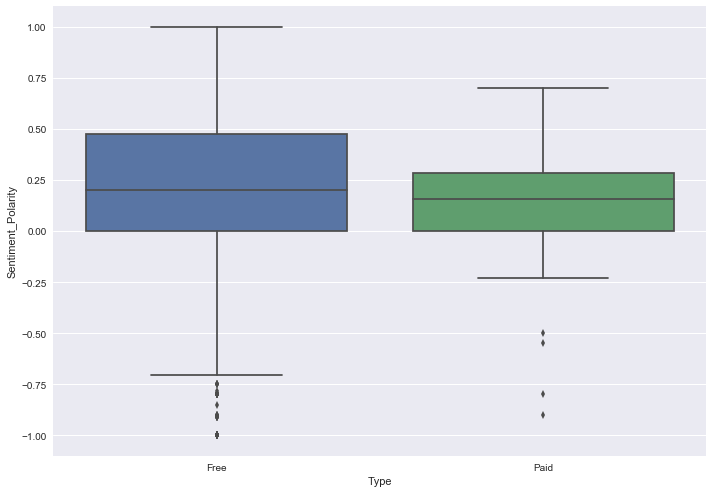

In [1597]:
#merged_df.loc[merged_df.Type=='Free']['Sentiment_Polarity']
sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
#ax = sns.stripplot(x="Type", y="Sentiment_Polarity", data=merged_df, color=".3")

**Free apps receive a lot of harsh comments** which are indicated as outliers on the negative Y-axis. Users are more lenient while reviewing a paid app than a free app.

## WORDCLOUD - A quick look on Free apps Vs Paid apps

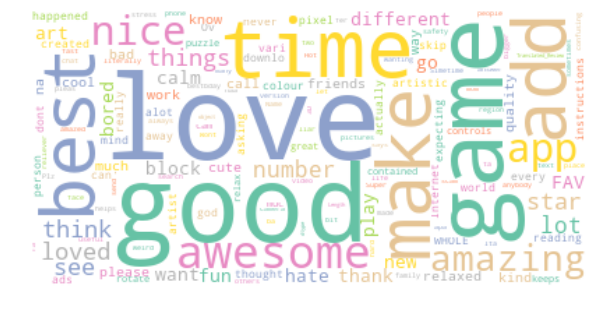

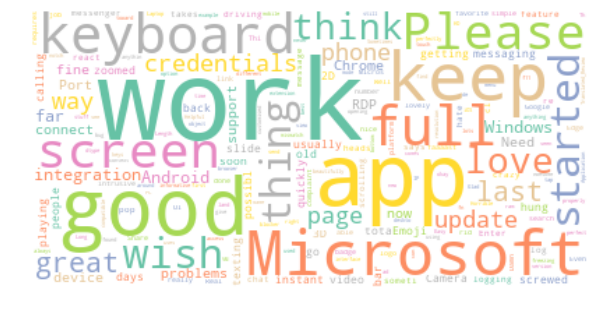

In [1621]:
# reviews_df = pd.read_csv('googleplaystore_sentiment_analysis.csv')
# merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")

from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=200, colormap="Set2")
# generate word cloud

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop + ['app', 'ap', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download']

merged_df['Translated_Review'] = merged_df['Translated_Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
merged_df.dropna(subset=['Translated_Review'], inplace=True)
#print(any(merged_df.Translated_Review.isna()))


free = merged_df.loc[merged_df.Type=='Free']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


paid = merged_df.loc[merged_df.Type=='Paid']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(paid)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# CONCLUSION
 - Average rating of (active) apps on Google Play Store is 4.28
 
 
 - **Users prefer to pay for apps that are light-weighted.** Thus, a paid app that is bulky may not perform well in the market.
 
 
 - Most of the high rated apps are **optimally sized between ~2MB to ~40MB** - neither too light nor too heavy.
 
 
 - Customers tend to download a given app more if it has been reviewed by a large number of people.